# IS 445 Final Project
## Group 4 - Earthquake Visualization Dashboard

In [17]:
import json
import numpy as np
import pandas as pd
import urllib.request
import folium
from folium.plugins import MarkerCluster
from datetime import datetime
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cartopy
import seaborn as sns
import ipywidgets
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

In [18]:
df = pd.read_csv("EarthquakeData_12092020-12162020.csv", parse_dates = ["time"])

In [19]:
df['date'] = pd.DatetimeIndex(df['time']).date
df_by_date = df.groupby("date")

In [20]:
df_horizontalError = df[['horizontalError','place']].sort_values('horizontalError', ascending=False).nlargest(10, 'horizontalError')
df_magError = df[['magError','place']].sort_values('magError', ascending=False).nlargest(10, 'magError')
df_depthError = df[['depthError','place']].sort_values('depthError', ascending=False).nlargest(10, 'depthError')

df_magError = df_magError.sort_values('magError', ascending=False).drop_duplicates(['place'])
df_horizontalError = df_horizontalError.sort_values('horizontalError', ascending=False).drop_duplicates(['place'])
df_depthError = df_depthError.sort_values('depthError', ascending=False).drop_duplicates(['place'])

In [21]:
def get_latest_earthquake_view():
    """
    Display the latest earthquake map
    """
    # download the earthquake data
    with urllib.request.urlopen('https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_hour.geojson') as url:
        data = json.loads(url.read().decode())
        
    # Get the core data from the JSON.
    features = data['features']
    df = pd.DataFrame()
    lat_list = []
    long_list = []
    mag_list = []
    place_list = []
    time_list = []
    
    for earthquake in features:
        long_list.append(earthquake['geometry']['coordinates'][0])
        lat_list.append(earthquake['geometry']['coordinates'][1])
        mag_list.append(earthquake['properties']['mag'])
        place_list.append(earthquake['properties']['place'])
        time_list.append(earthquake['properties']['time'])
        
    df['place'] = place_list
    df['long'] = long_list
    df['lat'] = lat_list
    df['mag'] = mag_list
    df['time'] = time_list
    
    # Create an empty map first
    us_center = [37.09, -95.72]
    themap = folium.Map(location=us_center, zoom_start=2)
    
    for index, row in df.iterrows():
        NL = '<br/>'
        
        info = 'Location: ' + row['place'] + NL +        \
               'Mag: ' + str(row['mag']) + NL +          \
               'Lat: ' + str(row['lat']) + NL +          \
               'Long: ' + str(row['long']) + NL +        \
               'Datetime: ' + str(datetime.fromtimestamp(row['time'] / 1000))
        
        popup_iframe = folium.IFrame(info,
                                    width=200,
                                    height=150)
        popup_info = folium.Popup(popup_iframe, width=100)
        folium.Marker([row['lat'], row['long']], popup=popup_info).add_to(themap)
    
    title_html = '''
    <h3 align="center" style="font-size:20px"><b>Latest Earthquake Map</b></h3>
    '''
    # Add a title to the map
    themap.get_root().html.add_child(folium.Element(title_html))
    display(themap)

# Historical Earthquake Data
## From 12/09/20 - 12/16/20 ##

interactive(children=(Dropdown(description='date', options=(datetime.date(2020, 12, 16), datetime.date(2020, 1…

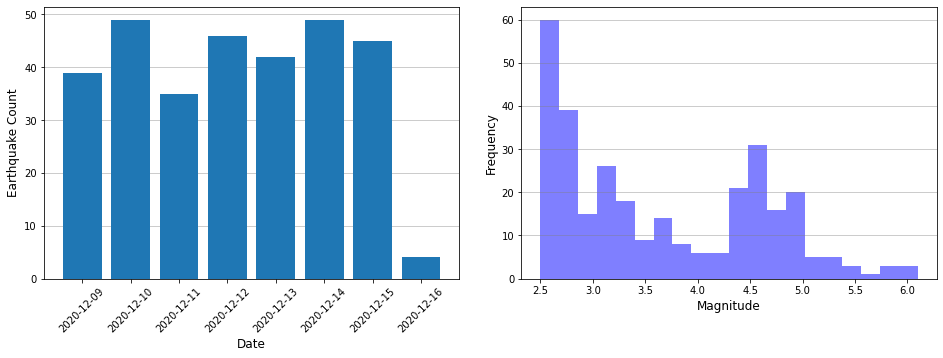

In [22]:
labels = df['date'].unique()

# plot the interactive map
@ipywidgets.interact(date = labels)
def date_filter(date):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111, projection = cartopy.crs.PlateCarree())
    ax.set_global()
    ax.gridlines()
    ax.coastlines()
    for i in range(len(labels)): 
        df_date = df[df["date"]==date]
        fig_map = plt.scatter(df_date["longitude"], df_date["latitude"], 
                   transform = cartopy.crs.PlateCarree(), s = df_date["mag"]*100,
                   c = df_date["mag"], vmin = 0, vmax = df['mag'].max(), 
                   cmap="inferno", alpha=0.12)
    cb = plt.colorbar(orientation = 'vertical', fraction=0.024, pad=0.02)
    cb.set_alpha(1)
    cb.draw_all()
    cb.ax.tick_params(labelsize='x-large')

# plot the bar chart for the date  
grid = plt.GridSpec(1, 2, wspace=0.15, hspace=0.5)
plt.figure(figsize=(16, 5))
plt.subplot(grid[0,0])
plt.bar(df_by_date.size().index, df_by_date.size(), zorder=2)
plt.xlabel("Date", fontsize = 12)
plt.ylabel("Earthquake Count", fontsize = 12)
plt.xticks(rotation = 45)
plt.grid(axis = 'y', color = 'grey', alpha=0.5, zorder=0)

# plot the histogram for the magnitude data
plt.subplot(grid[0,1])
num_bins = 20
n, bins, patches = plt.hist(df['mag'], num_bins, facecolor='blue', alpha=0.5)

plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Magnitude', fontsize = 12)
plt.grid(axis = 'y', color = 'grey', alpha=0.5, zorder=0)

# Real-time Earthquake Data
###### Refresh by rerunning the function

In [23]:
get_latest_earthquake_view()

# Earthquake Data Analysis
#### Focusing on magnitude error, depth error, and horizontal error

In [24]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(
   go.Bar(x=df_magError['place'], y=df_magError["magError"], name="Magnitude Error"),
   row=1, col=1
)

fig.add_trace(
   go.Bar(x=df_horizontalError['place'], y=df_horizontalError["horizontalError"], name="Horizontal Error (km)"),
   row=1, col=2
)

fig.add_trace(
   go.Bar(x=df_depthError['place'], y=df_depthError["depthError"], name="Depth Error (km)"),
   row=1, col=3
)

fig.update_layout(height=600, width=800, title_text="Top 10 places with highest magnitude error, horizontal error and depth error")
fig.show()